<a href="https://colab.research.google.com/github/ashwaniashu29/GenAIBootCamp/blob/main/Exercises/Exercises/5-NewsClassification_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon May 13 09:59:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install textblob 'keras-nlp' 'keras-preprocessing' 'gensim==4.2.0' np_utils swifter 'tensorflow-text==2.15.0'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.3/515.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 32.6 MB/s eta 0:00:00
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56441 sha256=76e8d5d786dab4ad0ef1148c4d654c271f03aec894c0add31327ab7516739cb1
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=8086c4

In [3]:
import multiprocessing
import tensorflow as tf
import sys
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda, ELU, Conv1D, MaxPooling1D, Dropout
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from textblob import TextBlob, Word
from keras_preprocessing.sequence import pad_sequences
from keras.initializers import Constant
import numpy as np
import random
import os
import pandas as pd
import gensim
import warnings
import nltk
import pickle
from tensorflow.nn import leaky_relu

import re
import warnings
from sklearn.model_selection import train_test_split
from textblob import TextBlob

TRACE = False
embedding_dim = 300
epochs=100
batch_size = 250
corpus_size=25000
BATCH = True

def set_seeds_and_trace():
  os.environ['PYTHONHASHSEED'] = '0'
  np.random.seed(42)
  tf.random.set_seed(42)
  random.seed(42)
  if TRACE:
    tf.debugging.set_log_device_placement(True)

def set_session_with_gpus_and_cores():
  cores = multiprocessing.cpu_count()
  gpus = len(tf.config.list_physical_devices('GPU'))
  config = tf.compat.v1.ConfigProto( device_count = {'GPU': gpus  , 'CPU': cores} , intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(config=config)
  tf.compat.v1.keras.backend.set_session(sess)

set_seeds_and_trace()
set_session_with_gpus_and_cores()
warnings.filterwarnings('ignore')
nltk.download('punkt')
textblob_tokenizer = lambda x: TextBlob(x).words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
%%writefile get_data.sh
if [ ! -f news.csv ]; then
  wget -O news.csv https://www.dropbox.com/s/352x7xzivf60zgc/news.csv?dl=0
fi

Writing get_data.sh


In [5]:
!bash get_data.sh

--2024-05-13 10:01:29--  https://www.dropbox.com/s/352x7xzivf60zgc/news.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/352x7xzivf60zgc/news.csv [following]
--2024-05-13 10:01:30--  https://www.dropbox.com/s/raw/352x7xzivf60zgc/news.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8046438fd226ba1ca6c34e4fe6.dl.dropboxusercontent.com/cd/0/inline/CSwoWIlHCdnnK6PAdBpu23g3_ZZCrYJsOeb9vOVBvZozW_M8jAw_9HwM_PIV6dzW6V4hd0XzFd0x46EkWMb9iqmLh-UxNXSQU5jouF521IlJdGWeEeO5KeYINX-3uUufYKNurRd4ri3xzN-wxvw3-zlt/file# [following]
--2024-05-13 10:01:30--  https://uc8046438fd226ba1ca6c34e4fe6.dl.dropboxusercontent.com/cd/0/inline/CSwoWIlHCdnnK6PAdBpu23g3_ZZCrYJsOeb9vOVBvZozW_M8jAw_9HwM_PIV6dzW6V4hd0XzFd0x46EkWMb9iqmLh-UxNXSQU5jouF521IlJd

In [6]:
path = './news.csv'
news_pre = pd.read_csv(path, header=0).sample(n=corpus_size).reset_index(drop=True)

In [12]:
news_pre.head()

,category,title
0,Business,"BBC set for major shake-up, claims newspaper"
1,Business,Marsh averts cash crunch
2,Sports,"Jeter, Yankees Look to Take Control (AP)"
3,Sci/Tech,Flying the Sun to Safety
4,Business,Stocks Seen Flat as Nortel and Oil Weigh


In [22]:
import string
def preprocess_text(text, should_join=True):
    # Tokenize into words
    tokens = text.split()

    # Lowercase the tokens
    tokens = [token.lower() for token in tokens]

    # Remove punctuation from each token
    tokens = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]

    if should_join:
        return ' '.join(gensim.utils.simple_preprocess(' '.join(tokens)))
    else:
        return gensim.utils.simple_preprocess(' '.join(tokens))


In [23]:
preprocessed_text = news_pre['title'].apply(lambda x: preprocess_text(x, should_join=True))

In [34]:
import swifter
# Use swifter to apply the preprocessin and save that pandas series to a file
news = preprocessed_text.swifter.apply(preprocess_text)
# Save the preprocessed Pandas Series to a file (e.g., CSV)
news.to_csv('news_processed.csv', index=False)



Pandas Apply:   0%|          | 0/25000 [00:00<?, ?it/s]

In [28]:

class MyCorpus:
    """An iterator that yields sentences (lists of str)."""

    def __iter__(self):
        corpus_path = 'news_processed.csv'
        for line in open(corpus_path):
            # assume there's one document per line, tokens separated by whitespace
            yield preprocess_text(line, should_join=False)


word2vec_model = gensim.models.Word2Vec(sentences=MyCorpus(), vector_size=100, window=5, min_count=1, workers=4)
# Get a word2vec model using gensim.models and passing the sentences using MyCorpus()

# Optionally, save the trained model to a file
word2vec_model.save('word2vec_model.bin')


In [31]:
import gensim

# Load the trained Word2Vec model
word2vec_model = gensim.models.Word2Vec.load('word2vec_model.bin')

weights = word2vec_model.wv.vectors

# Convert the embedding weights to a TensorFlow tensor
_tensor = tf.convert_to_tensor(weights)

# Print the shape of the embedding tensor
print("Shape of the embedding tensor:", _tensor.shape)

vocab_size = None  # get vocab size from index_to_key in word2vec_model.wv

# Get the vocabulary size from index_to_key
vocab_size = len(word2vec_model.wv.index_to_key)

print("Vocabulary size:", vocab_size)

Shape of the embedding tensor: (18902, 100)
Vocabulary size: 18902


In [32]:
weights.shape

(18902, 100)

In [35]:
news_preprocessed = pd.DataFrame()
news_preprocessed['label'] = news_pre.category.map({'Business': 0, 'Sports': 1, 'Sci/Tech': 2, 'World': 3})
news_preprocessed['title'] = news
news_preprocessed

,label,title
0,0,bbc set for major shakeup claims newspaper
1,0,marsh averts cash crunch
2,1,jeter yankees look to take control ap
3,2,flying the sun to safety
4,0,stocks seen flat as nortel and oil weigh
...,...,...
24995,0,walmart clarifies policy regarding unions ap
24996,2,viewpoint better russian planning would preven...
24997,1,no syracuse princeton
24998,1,usc oklahoma still auburn third in bcs


In [36]:
def get_maximum_review_length(df):
    maximum = 0
    for ix, row in df.iterrows():
        candidate = len(textblob_tokenizer(row.title))
        if candidate > maximum:
            maximum = candidate
    return maximum


maximum = get_maximum_review_length(news_preprocessed)   # Since 2 titles may have different number of words, we have to find the max length and fill with 0s if a title is shorter

In [37]:
X = np.zeros((len(news_preprocessed), maximum))   # Here we do what we said above
# Iterate through the news df and for every word, if it exists in the word2vec model, put into X for that review and that word the index of the embedding (check index_to_key)
# HINT: to iterate through a column of a pandas dataframe you do:

# for index, value in df.iterrows():
#      #do something
for i, (_, row) in enumerate(news_preprocessed.iterrows()):
    review_words = row['title'].split()  # Split the title into words
    for j, word in enumerate(review_words):
        if word in word2vec_model.wv:
            # If the word exists in the Word2Vec model's vocabulary,
            # find its index in the embedding space and store it in X
            word_index = word2vec_model.wv.index_to_key.index(word)
            X[i, j] = word_index
# FILL
y = news_preprocessed.label




In [39]:
import tensorflow as tf

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = tf.constant(X_train)
X_test = tf.constant(X_test)
# Convert y_train and y_test from an array of values between 0-3 to a one hot matrix tensor
num_classes = 4
y_train = tf.one_hot(y_train, num_classes)
y_test = tf.one_hot(y_test, num_classes)

In [51]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, GlobalAveragePooling1D
from keras.layers import LeakyReLU, BatchNormalization


model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,input_length=maximum))  # Add an Embedding layer with weights being the rweights variable and trainable as False. The embedding dimension should be embedding_dim

# Add Dense layers
model.add(Dense(64))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())

model.add(Dense(32))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())

# GlobalAveragePooling1D layer to average out the words of the sentence
#model.add(GlobalAveragePooling1D())

model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(None, embedding_dim,)))  # Average out the words of the sentence. The expected out is (N, D) where N is number f samples in batch and D is embedding dimension


# Add final Dense layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




In [52]:
# Compile the model. Think what is the best loss to use
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 300)         5670600   
                                                                 
 dense_12 (Dense)            (None, None, 64)          19264     
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, None, 64)          0         
                                                                 
 batch_normalization_8 (Bat  (None, None, 64)          256       
 chNormalization)                                                
                                                                 
 dense_13 (Dense)            (None, None, 32)          2080      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, None, 32)          0         
                                                      

In [53]:
X_train.shape

TensorShape([20000, 17])

In [54]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.01)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, callbacks=[callback])

Epoch 1/10
625/625 [==============================] - 17s 20ms/step - loss: 0.6802 - accuracy: 0.7603 - val_loss: 0.5417 - val_accuracy: 0.8194
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.2913 - accuracy: 0.9068 - val_loss: 0.5434 - val_accuracy: 0.8104
Epoch 3/10
625/625 [==============================] - 4s 7ms/step - loss: 0.1638 - accuracy: 0.9485 - val_loss: 0.6258 - val_accuracy: 0.7962
Epoch 4/10
625/625 [==============================] - 5s 9ms/step - loss: 0.1114 - accuracy: 0.9664 - val_loss: 0.7748 - val_accuracy: 0.7768


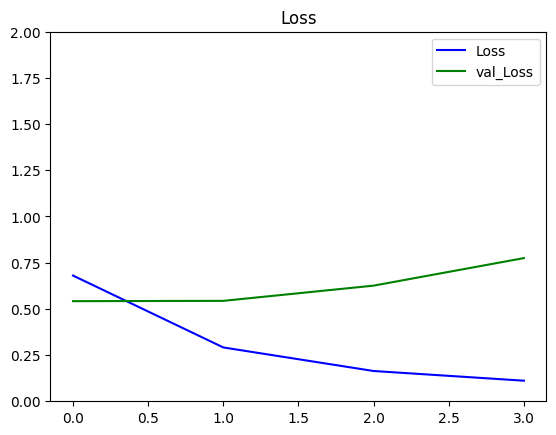

In [55]:
import matplotlib.pyplot as plt

# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=2.0)


In [60]:
# Test with the following two sentences:
# - 'supercomputer will put workers jobless soon'
# - 'patriots goes winning super bowl'

x_val = np.zeros((2, maximum))
for index, row in enumerate(['supercomputer will put workers jobless soon', 'patriots goes winning super bowl']):

    tokens = preprocess_text(row[index]).split()  # Preprocess and tokenize sentence
    for i, token in enumerate(tokens):
        if i >= maximum:
            break
        if token in word2vec_model.wv:
            word_index = word2vec_model.wv.index_to_key.index(token)
            x_val[index, i] = word_index
        else:
            # Handle out-of-vocabulary words (if needed)
            pass

y_val = tf.one_hot([0,1], depth=4)






In [59]:

print(y_val)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
tf.Tensor(
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]], shape=(2, 4), dtype=float32)
